In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import torch
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# location on Google Drive
master_path = '/content/drive/My Drive/'

classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

data_transform = transforms.Compose([transforms.RandomResizedCrop(64), 
                                      transforms.ToTensor()])

dataset = datasets.ImageFolder(master_path+'dataset/imgs', transform=data_transform)
subset = datasets.ImageFolder(master_path+'aps360_subset', transform=data_transform)

In [0]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(244),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(244),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader

data_dir = '/content/drive/My Drive/aps360_subset'
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [0]:
model = models.resnet50(pretrained=True)


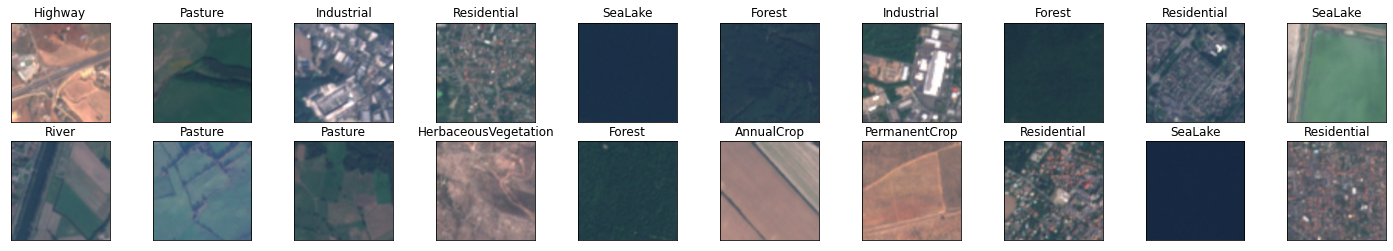

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() 
# convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [0]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
epochs = 5
steps = 0
running_loss = 0
print_every = 2
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Epoch 1/5.. Train loss: 2.632.. Test loss: 2.456.. Test accuracy: 0.100
Epoch 1/5.. Train loss: 2.724.. Test loss: 2.329.. Test accuracy: 0.225
Epoch 1/5.. Train loss: 2.365.. Test loss: 2.429.. Test accuracy: 0.100
Epoch 1/5.. Train loss: 1.826.. Test loss: 2.673.. Test accuracy: 0.200
Epoch 1/5.. Train loss: 2.570.. Test loss: 2.731.. Test accuracy: 0.125
Epoch 1/5.. Train loss: 2.571.. Test loss: 2.451.. Test accuracy: 0.150
Epoch 1/5.. Train loss: 1.766.. Test loss: 2.235.. Test accuracy: 0.125
Epoch 1/5.. Train loss: 2.023.. Test loss: 2.210.. Test accuracy: 0.225
Epoch 1/5.. Train loss: 1.783.. Test loss: 2.084.. Test accuracy: 0.175
Epoch 1/5.. Train loss: 1.632.. Test loss: 2.237.. Test accuracy: 0.125
Epoch 2/5.. Train loss: 1.555.. Test loss: 2.330.. Test accuracy: 0.200
Epoch 2/5.. Train loss: 1.601.. Test loss: 2.263.. Test accuracy: 0.350
Epoch 2/5.. Train loss: 1.745.. Test loss: 2.519.. Test accuracy: 0.150
Epoch 2/5.. Train loss: 2.104.. Test loss: 2.389.. Test accuracy

In [0]:
accuracy 

NameError: ignored

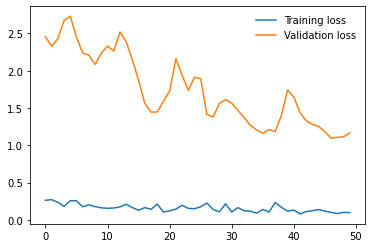

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [0]:
def get_random_images(num):
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [0]:
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

NameError: ignored

<Figure size 720x720 with 0 Axes>